In [479]:
import multiprocessing as mp

import string
import pickle
import numpy as np
import pandas as pd
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix

In [480]:
language = 'es'
assert(language in ['en', 'fr', 'es'])

In [481]:
numberbatch = pickle.load(open(f"/data/zeste_cache/numberbatch-{language}-19.08.pickle", 'rb'))

In [482]:
len(numberbatch.vocab)

651859

In [483]:
! ls datasets/silknow

en_material_post2.csv	  zeste_material_en_post.csv
en_technique_post2.csv	  zeste_material_es_post.csv
es_material_post2.csv	  zeste_technique_en_post.csv
es_technique_post2.csv	  zeste_technique_es_post.csv
es_visual_item_post2.csv  zeste_visual_item_es_post.csv


In [484]:
ds_techniques = pd.read_csv('datasets/silknow/es_material_post2.csv').rename(columns={'technique':'label'})
ds_techniques.label = ds_techniques.label.str.lower()
ds_techniques.head()

,text,label
0,Prenda de cabeza de forma semicircular realiza...,'silver thread'
1,Cubrecáliz realizado con seis piezas de tejido...,'silver thread'
2,Paño cuadrangular confeccionado con tejido de ...,'gold thread'
3,De forma cuadrada con armazón interior de cart...,'silver thread'
4,Renacimiento,'gold thread'


In [485]:
ds_techniques.label.value_counts()

'vegetable fibre'    225
'gold thread'         34
'silver thread'       10
Name: label, dtype: int64

In [486]:
len(ds_techniques)

269

In [487]:
def get_word_neighborhood(word, depth=2, allowed_rels='all', keep='top20000', language=language):
    neighborhood = pickle.load(open('/data/zeste_cache/neighborhoods_'+language+'/'+word+'.pickle', 'rb'))
    neighborhood_words = list(neighborhood.keys())
    
    if allowed_rels != 'all':
        for n in neighborhood_words:
            if all(rel not in neighborhood[n]['rels'] for rel in allowed_rels):
                del neighborhood[n]
                continue

    to_visit_next = list(neighborhood.keys())
    
    while depth > 1:
        additions = []
        while len(to_visit_next) > 0:
            w = to_visit_next.pop()
            nn = get_word_neighborhood(w, depth=1, allowed_rels=allowed_rels)
            for ww in nn:
                if ww in neighborhood:
                    neighborhood[ww]['from'].append(w)
                    neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                else:
                    neighborhood[ww] = {}
                    neighborhood[ww]['from'] = [w]
                    neighborhood[ww]['rels'] = nn[ww]['rels']
                    if '/c/'+language+'/'+word in numberbatch and '/c/'+language+'/'+ww in numberbatch:
                        neighborhood[ww]['sim'] = numberbatch.similarity('/c/'+language+'/'+word, '/c/'+language+'/'+ww)
                    else:
                        neighborhood[ww]['sim'] = 0.0
                    additions.append(ww)
        to_visit_next = additions
        depth -= 1
    
    if keep.startswith('top'):
        k = int(keep.split('top')[1])
        all_scores = [neighborhood[kw]['sim'] for kw in neighborhood]
        all_words = list(neighborhood.keys())
        if k < len(all_scores):
            lowest_top = sorted(all_scores, reverse=True)[k]
            for kw in all_words:
                if neighborhood[kw]['sim'] <= lowest_top:
                    del neighborhood[kw]
    
    return neighborhood

In [488]:
def preprocess(doc):
    doc = ''.join(c for c in doc if c not in string.punctuation or c == ' ').lower()
    doc_tokens = doc.split(' ')
    doc_tokens = [w.lower() for w in doc_tokens]
    doc_tokens = [w for w in doc_tokens if w not in stopwords.words('english')]
    doc_tokens = [w.replace('"', '').replace('?', '') for w in doc_tokens]
    doc_tokens = [w.replace('-', '_') for w in doc_tokens if w != '']

    return doc_tokens

In [489]:
def get_words_neighborhood(words, depth=2, allowed_rels='all', keep='top20000', language=language):
    words = words.split(';')
    ns = []
    
    for word in words:
        ns.append(get_word_neighborhood(word, depth=depth, allowed_rels=allowed_rels, keep=keep, language=language))
    neighborhood = ns[0].copy()
    
    for w, nn in zip(words[1:], ns[1:]):
        for ww in nn:
            if ww in neighborhood:
                neighborhood[ww]['from'].append(w)
                neighborhood[ww]['rels'].extend(['<>'] + nn[ww]['rels'])
                neighborhood[ww]['sim'] = max(neighborhood[ww]['sim'], nn[ww]['sim'])
            else:
                neighborhood[ww] = {}
                neighborhood[ww]['from'] = [w]
                neighborhood[ww]['rels'] = nn[ww]['rels']
                neighborhood[ww]['sim']  = nn[ww]['sim']

    return neighborhood

In [490]:
sorted(ds_techniques.label.unique())

["'gold thread'", "'silver thread'", "'vegetable fibre'"]

In [491]:
get_word_neighborhood('rose', 1, 'all').keys()

dict_keys(['rose', 'rosal', 'rosáceo', 'rosa', 'rosado', 'rosaleda', 'rosalista', 'pimpollo'])

In [492]:
"""mapping = {  'brocade': 'brocade',
             'brocatelle': 'brocatelle',
             'chiné': 'chiné',
             'damask': 'damask',
             'embroidery': "embroidery",
             'florentine': "florentine",
             'gros': "gros",
             'jacquard weave': "jacquard_loom",
             'lampas': "lampas",
             'moiré' : 'moiré',
             'pattern weft': "weft",
             'plain': "plain",
             'velvet': "velvet"}"""

mapping = { "'vegetable fibre'": "vegetal",
            "'silver thread'": "plata",
            "'gold thread'": "oro",
}

labels = sorted(set(mapping.values()))
print(len(labels))
print(labels)

3
['oro', 'plata', 'vegetal']


In [493]:
%%time
pbar = tqdm(labels)

labels_cgr = {}
for label in pbar:
    pbar.set_description(label)
    labels_cgr[label] = get_words_neighborhood(label, 2, 'all', keep='top20000')


CPU times: user 77.7 ms, sys: 3.35 ms, total: 81 ms
Wall time: 75.1 ms


In [494]:
{l:len(labels_cgr[l]) for l in labels_cgr}

{'oro': 510, 'plata': 405, 'vegetal': 140}

In [495]:
labels_cgr.keys()

dict_keys(['oro', 'plata', 'vegetal'])

In [496]:
def get_document_score(doc, label_neighborhood):
    # tokens = preprocess(doc)
    if type(doc) == str:
        doc = doc.split(' ')
    tokens = doc
    related_words = []
    score = 0
    for token in tokens: 
        if token in label_neighborhood:
            similarity = label_neighborhood[token]['sim']
            if similarity > 0:
                related_words.append((token, label_neighborhood[token]['rels'][0], similarity))
                score += similarity
        
    return score# , sorted(related_words, key=lambda t: -t[-1])

In [497]:
ds_techniques.text[0]

'Prenda de cabeza de forma semicircular realizada con dos piezas de tejido, la menor colocada en sentido transversal, con ligamento de seda de color salmón con decoración realizada en seda azul, verde, blanca e hilos metálicos de plata y plata sobredorada. La decoración principal se reparte alternándose en bandas, en las que se suceden los ramos vegetales en azul y blanco con león rampante en hilo dorado, con otras en las que aparece el mismo ramo vegetal en este caso verde y un ave empenachada en hilo de plata. Los espacios resultantes se completan con pequeñas ramitas con hojas y frutos que se alternan según la hilera con ovejas adornadas con lazo y pequeños jabalíes.   \nLa prenda aparece rematada perimetralmente por puntilla de encaje tipo Puntos de España realizada con hilo metálico de plata sobredorada.'

In [498]:
data_silknow = ds_techniques.text.tolist()

In [499]:
print("Number of processors: ", mp.cpu_count())

Number of processors:  32


In [500]:
%%time
with mp.Pool(mp.cpu_count()) as pool:
    data_preprocessed = pool.map(preprocess, ds_techniques.text)

CPU times: user 54.4 ms, sys: 1.37 s, total: 1.42 s
Wall time: 1.42 s


In [501]:
def scoring_silknow(doc, labels_ns=labels_cgr):
    return np.argmax([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])

In [502]:
def generate_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow, corpus_preprocessed)
    return predictions

In [503]:
%%time
predictions = generate_predictions(data_preprocessed, labels_cgr)

CPU times: user 44.5 ms, sys: 1.29 s, total: 1.33 s
Wall time: 1.33 s


In [504]:


predictions[:10]

[1, 1, 0, 1, 0, 0, 0, 0, 1, 1]

In [505]:

prediction_labels = [labels[p] for p in predictions]

In [506]:
set(prediction_labels)

{'oro', 'plata', 'vegetal'}

In [507]:
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]

# Materials

In [508]:
print(classification_report(prediction_labels, true_labels, digits=3))
m = np.asarray(prediction_labels)
ds_techniques["predictions"] = m 
ds_techniques.to_csv('material-es-predictions.csv')

              precision    recall  f1-score   support

         oro      0.706     0.103     0.179       234
       plata      0.500     0.172     0.256        29
     vegetal      0.027     1.000     0.052         6

    accuracy                          0.130       269
   macro avg      0.411     0.425     0.162       269
weighted avg      0.669     0.130     0.185       269



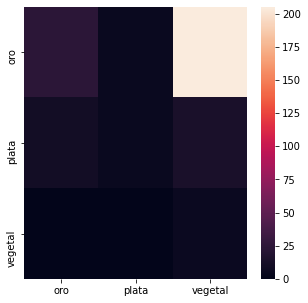

In [509]:
cm = confusion_matrix(prediction_labels, true_labels)
cm_df = pd.DataFrame(cm, columns=labels, index=labels)
plt.figure(figsize = (5,5))
sns.heatmap(cm_df)

# "Top-k" evaluation

In [510]:
k = 2
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

         oro      0.500     0.773     0.607        22
       plata      0.800     0.400     0.533        20
     vegetal      0.933     0.925     0.929       227

    accuracy                          0.874       269
   macro avg      0.744     0.699     0.690       269
weighted avg      0.888     0.874     0.873       269



In [511]:
k = 3
def scoring_silknow_top_n(doc, labels_ns=labels_cgr, n=k):
    return np.argsort([get_document_score(doc, labels_ns[l]) for l in sorted(labels_ns.keys())])[:-(n+1):-1]
def generate_top_predictions(corpus_preprocessed, labels_cgr):
    with mp.Pool(processes=mp.cpu_count()) as pool:
        predictions = pool.map(scoring_silknow_top_n, corpus_preprocessed)
    return predictions
true_labels = [mapping[l] for l in ds_techniques.label.tolist()]
topk_predictions_lists = generate_top_predictions(data_preprocessed, labels_cgr)
prediction_labels_lists = [[labels[l] for l in p] for p in topk_predictions_lists]
topk_predictions = []

for i, gt_label in enumerate(true_labels):
    topk_predictions.append(gt_label if gt_label in prediction_labels_lists[i] else prediction_labels_lists[i][0])
print(classification_report(topk_predictions, true_labels, digits=3))

              precision    recall  f1-score   support

         oro      1.000     1.000     1.000        34
       plata      1.000     1.000     1.000        10
     vegetal      1.000     1.000     1.000       225

    accuracy                          1.000       269
   macro avg      1.000     1.000     1.000       269
weighted avg      1.000     1.000     1.000       269

